<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>DRAFT: Coadd Recreation</b> <br>
Contact author: Melissa Graham <br>
Last verified to run: <i>yyyy-mm-dd</i> <br>
LSST Science Piplines version: Weekly 2022_22 <br>
Container Size: large <br>
Targeted learning level: intermediate <br>

In [1]:
# %load_ext pycodestyle_magic
# %flake8_on
# import logging
# logging.getLogger("flake8").setLevel(logging.FATAL)

**Description:** Recreate a deepCoad using only a subset of the input visits.

**Skills:** Use of pipetasks for image coaddition. Creating and writing to Butler collections. Properties of deepCoadds.

**LSST Data Products:** DP0.2 images: deepCoadd. DP0.2 catalogs: visitTable.

**Packages:** lsst.daf.butler, lsst.ctrl.mpexec, lsst.pipe.base

**Credit:** Originally developed by Melissa Graham and Clare Saunders.

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0-2.lsst.io">dp0-2.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

This notebook shows how to retrieve information about the individual images that contributed to a deepCoadd, and how to make a new coadded image using only a subset of the inputs.

In the past you might have used iraf's imcombine or Astromatics's SWarp (for example) to coadd images.
This notebook demonstrates the appropriate methods for coadding LSST images with the LSST Science Pipelines.

Science applications of coadding a subsets of LSST images includes searching for faint, slowly-evolving transients or variables (e.g.,, coadding images by season), using the effects of differential chromatic refraction (e.g., coadding images in bins of airmass), or perhaps searching for low surface brightness features (e.g., coadding only dark-time images with the faintest sky backgrounds).

### 1.1. Package imports

In [2]:
# standard python packages for numerical processing, plotting, and databases
import time
import getpass
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas

# astropy package for time unit conversions
from astropy.time import Time

# lsst packages for data access and display
import lsst.geom
import lsst.afw.display as afwDisplay

# import lsst.daf.butler as dafButler
from lsst.daf.butler import Butler, DatasetType, CollectionType

# lsst packages for executing pipeline tasks
from lsst.ctrl.mpexec import SimplePipelineExecutor
from lsst.pipe.base import Pipeline, Instrument

### 1.2. Define functions and parameters

Set a few parameters related to plotting and display.

In [3]:
font = {'size': 14}
matplotlib.rc('font', **font)

pandas.set_option('display.max_rows', 1000)

afwDisplay.setDefaultBackend('matplotlib')

Set the DP0.2 config and collection, and instantiate the butler.

In [4]:
config = 'dp02'
collection = '2.2i/runs/DP0.2'

> **Notice:** It is OK to ignore a pink-window message saying "WARNING: version mismatch between CFITSIO header (v4.000999999999999) and linked library (v4.01)."

In [5]:
butler = Butler(config, collections=collection)

Option to display all the deepCoadd datasetTypes available via our butler.

In [6]:
# for x in sorted(butler.registry.queryDatasetTypes()):
#     temp = str(x)
#     if temp.find('deepCoadd') > -1:
#         print(x)
#     del temp

## 2. Identify the visits to combine

This example starts with a given sky coordinate -- in this case, the right ascension and declination of a known galaxy cluster in the DC2 data set are used.

The DC2 skyMap is used to identify the deepCoadd which contains that coordinate, and then the butler is used to retrieve the deepCoadd and the list of visit ids which were combined to create it.

The visitTable is then used to obtain the acquisition dates of the input visits.
For this example, the visits in two short time ranges have been arbitrarily selected as the visits to be coadded.

### 2.1. Identify and retrieve the deepCoadd

This takes 4-5 seconds.

In [7]:
%%time

my_ra_deg = 55.745834
my_dec_deg = -32.269167

my_spherePoint = lsst.geom.SpherePoint(my_ra_deg*lsst.geom.degrees,
                                       my_dec_deg*lsst.geom.degrees)

skymap = butler.get('skyMap')
tract = skymap.findTract(my_spherePoint)
my_tract = tract.tract_id
my_patch = tract.findPatch(my_spherePoint).getSequentialIndex()
print('My tract and patch: ', my_tract, my_patch)

my_dataId = {'band': 'i', 'tract': my_tract, 'patch': my_patch}
my_deepCoadd = butler.get('deepCoadd', dataId=my_dataId)

del my_ra_deg, my_dec_deg, my_spherePoint, tract

My tract and patch:  4431 17
CPU times: user 3.51 s, sys: 1.21 s, total: 4.72 s
Wall time: 5.64 s


Option to display the deepCoadd image.

In [8]:
# fig = plt.figure(figsize=(6, 4))
# afw_display = afwDisplay.Display(1)
# afw_display.scale('asinh', 'zscale')
# afw_display.mtv(my_deepCoadd.image)
# plt.gca().axis('off')

Option to learn more about the deepCoadd metadata, such as bounding box, corners, and the World Coordinate System (WCS).
It is not necessary to know the bounding box for a deepCoadd in order to find all of the calexps that were used to assemble it, this is simply a demonstration for the learner.

In [9]:
# my_deepCoadd_bbox = butler.get('deepCoadd.bbox', dataId=my_dataId)
# print('bbox')
# print(my_deepCoadd_bbox.beginX, my_deepCoadd_bbox.beginY,
#       my_deepCoadd_bbox.endX, my_deepCoadd_bbox.endY)

# print('')
# print('corners')
# print(my_deepCoadd_bbox.getCorners())

# print('')
# print('wcs')
# my_deepCoadd_wcs = butler.get('deepCoadd.wcs', dataId=my_dataId)
# print(my_deepCoadd_wcs)

# del my_deepCoadd_bbox, my_deepCoadd_wcs

### 2.2. Retrieve the deepCoadd's input visits

This takes 2-3 seconds.

In [10]:
%%time

my_coadd_inputs = butler.get("deepCoadd_calexp.coaddInputs", my_dataId)

CPU times: user 2.07 s, sys: 889 ms, total: 2.96 s
Wall time: 3.04 s


Option to display the coadd inputs as an astropy table.

In [11]:
# my_coadd_inputs.visits.asAstropy()

The length of this table, 161, indicates that 161 separate visits contributed to this deepCoadd.

In [12]:
len(my_coadd_inputs.visits)

161

Option to list all of the deepCoadd input visit ids.

In [13]:
# my_coadd_visits = my_coadd_inputs.visits['id']
# my_coadd_visits

### 2.3. Identify the acquisition dates for the input visits

First, get the entire visit table.

In [14]:
visitTableRef = list(butler.registry.queryDatasets('visitTable'))

In [15]:
visitTable = butler.get(visitTableRef[0])

Option to display the contents of the visitTable.

In [16]:
# visitTable

The fact that the id column for both the my_coadd_inputs.vists table and the visitTable is the visit number (visit id) makes it simple to retrieve the MJDs of our coadd input visits.

In [17]:
my_coadd_visits_mjds = visitTable.loc[my_coadd_inputs.visits['id']]['expMidptMJD']

These list of MJDs have 161 elements, for the 161 separate visits contributed to this deepCoadd.

In [18]:
len(my_coadd_visits_mjds)

161

### 2.4. Identify input visits to combine into a new Coadd

Say, for the sake of a science example, that a supernova exploded on MJD = 60960.

As a user, we want to stack images first from the month before to look for a faint precursor, and then maybe also the month before that.

Thus, we identify input visits in two date ranges:

Window1: 60925 to 60955 (the month before)

Window2: 60885 to 60922 (the month before that)

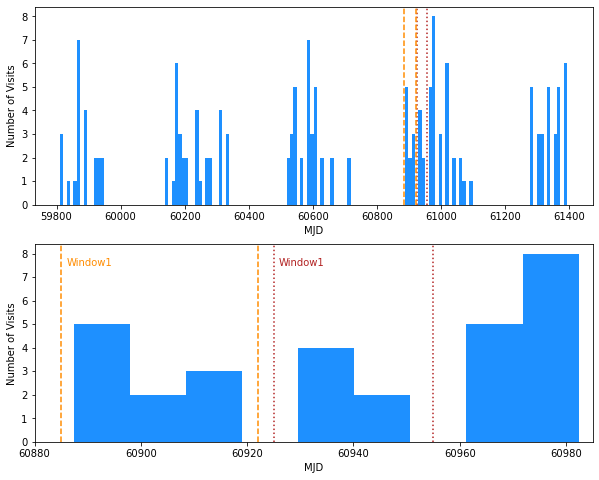

In [19]:
Window1_start = 60925
Window1_end = 60955

Window2_start = 60885
Window2_end = 60922

fig, ax = plt.subplots(2, figsize=(10, 8))

ax[0].hist(my_coadd_visits_mjds, bins=150, color='dodgerblue')
ax[0].set_xlabel('MJD')
ax[0].set_ylabel('Number of Visits')
ax[0].axvline(Window1_start, ls='dotted', color='firebrick')
ax[0].axvline(Window1_end, ls='dotted', color='firebrick')
ax[0].axvline(Window2_start, ls='dashed', color='darkorange')
ax[0].axvline(Window2_end, ls='dashed', color='darkorange')

ax[1].hist(my_coadd_visits_mjds, bins=150, color='dodgerblue')
ax[1].set_xlabel('MJD')
ax[1].set_ylabel('Number of Visits')
ax[1].set_xlim([60880, 60985])
ax[1].axvline(Window1_start, ls='dotted', color='firebrick')
ax[1].axvline(Window1_end, ls='dotted', color='firebrick')
ax[1].text(Window1_start+1, 7.5, 'Window1', color='firebrick')
ax[1].axvline(Window2_start, ls='dashed', color='darkorange')
ax[1].axvline(Window2_end, ls='dashed', color='darkorange')
ax[1].text(Window2_start+1, 7.5, 'Window1', color='darkorange')

plt.show()

There are six visits in Window1, and ten in Window2.

## 3. Create a coadd for the visits in Window1

Put the list of visits for Window1 into a string, formatted as a tuple, for use in a query later on.
("Formatted as a tuple" means within round brackets and separated by commas).

In [20]:
my_range = np.array((my_coadd_visits_mjds > Window1_start) & 
                    (my_coadd_visits_mjds < Window1_end))
my_visits = my_coadd_inputs.visits[my_range]
my_visits_tupleString = "("+",".join(my_visits['id'].astype(str))+")"
print(my_visits_tupleString)

(919515,924057,924085,924086,929477,930353)


### 3.1. Name a new butler collection for your output

> **Important:** Use the convention `u/[Your User Name]/coadd_recreation_nb` to set up a new output collection for this tutorial.
Recall that RSP user names are the same as GitHub user names, because GitHub accounts are used to authorize access to the RSP.

In [21]:
my_username = getpass.getuser()
my_outputCollection = 'u/'+my_username+'/coadd_recreation_nb'
print('Name of new butler collection for my output: ', my_outputCollection)

Name of new butler collection for my output:  u/melissagraham/coadd_recreation_nb


Check if this output collection already exists? If nothing is printed below this cell, the output collection does not already exist.

In [22]:
for c in sorted(butler.registry.queryCollections()):
    if c.find(my_outputCollection) > -1:
        print(c)

Delete the current butler. In the next section, a simple butler is created and used thereafter.

In [23]:
del butler

### 3.2. Set up a simple butler and name the output run for Window1

> **Notice:** In future updates to the LSST Science Pipelines, it will be possible to use: <br>
`simpleButler = SimplePipelineExecutor.prep_butler(config, inputs=[collection], output=my_outputCollection)`

For the LSST Science Pipelines version Weekly_2022_22, the following workaround is needed to set up a simple butler and create a new output collection with the name selected above.

Users have the option of defining the name of the `outputRun` to be whatever they want.

For example, to name an `outputRun` using a unique timestamp, use: <br>
`outputRun = f"{my_outputCollection}/{Instrument.makeCollectionTimestamp()}"` <br>
Timestamps are year month day T hour minute second Z, where the time is UTC.

But in this case, we will just use `TestWindow1` as our `outputRun` name.

In [24]:
outputRun = f"{my_outputCollection}/TestWindow1"

tmpButler = Butler(config, writeable=True)

tmpButler.registry.registerCollection(outputRun, CollectionType.RUN)
print('Made CollectionType.RUN: ', outputRun)

tmpButler.registry.registerCollection(my_outputCollection, CollectionType.CHAINED)
print('Made CollectionType.CHAINED: ', my_outputCollection)

collections = [collection]
collections.insert(0, outputRun)

tmpButler.registry.setCollectionChain(my_outputCollection, collections)

simpleButler = Butler(butler=tmpButler, collections=[my_outputCollection], run=outputRun)

del tmpButler

Made CollectionType.RUN:  u/melissagraham/coadd_recreation_nb/TestWindow1
Made CollectionType.CHAINED:  u/melissagraham/coadd_recreation_nb


Check that the subdirectory of the newly created output collection is first in the list.
The output will go into that specific RUN collection.

In [25]:
simpleButler.registry.getCollectionChain(my_outputCollection)

CollectionSearch(('u/melissagraham/coadd_recreation_nb/TestWindow1', '2.2i/runs/DP0.2'))

Option: check the output collection run names that currently exist.

In [27]:
# for c in sorted(simpleButler.registry.queryCollections()):
#     if c.find(my_outputCollection) > -1:
#         print('Found: ', c)

### 3.3. Select the makeWarp and assembleCoadd tasks

In order to combine the identified visits into a new Coadd, two steps of the larger Data Release pipeline must be included: makeWarp and assembleCoadd. 
Although warped images are created during processing, they are not stored long-term because they take up a lot of space and because they can be easily recreated when needed.

Find relevant documentation for more information about <a href="https://pipelines.lsst.io/v/weekly/modules/lsst.pipe.base/creating-a-pipeline.html">creating a pipeline</a> or the <a href="https://pipelines.lsst.io/modules/lsst.pipe.tasks/tasks/lsst.pipe.tasks.assembleCoadd.AssembleCoaddTask.html">assembleCoadd<a> task.

The following method for creating the `assembleCoaddPipeline` task in a notebook -- using the `from_uri` function and passing a file path -- is not intuitive, but is preferred because it gives the user all of the configuration settings for the instrument automatically, and because it most closely replicates the command-line syntax.

In [28]:
assembleCoaddPipeline = Pipeline.from_uri('${PIPE_TASKS_DIR}/pipelines/DRP.yaml#makeWarp,assembleCoadd')

The other tasks available are listed in the yaml file. 
To see the other tasks, first open a new terminal (click the blue + button at upper left and then select terminal).
Then create a Rubin Observatory environment, navigate to the DRP.yaml file, and view its contents with:
> `setup lsst_distrib` <br>
> `cd ${PIPE_TASKS_DIR}/pipelines/`<br>
> `more DRP.yaml`

When attempting to use `more` on the DRP.yaml file, a redirect to its true location might be returned. If so, follow the path given.

### 3.4. Configure the pipeline

Configurations can be set using `addConfigOverride(<taskName>, <configName>, <configValue>)`.

There is only one configuration that must be set, and it is to clarify to the pipeline that it _does not_ need to redo a final image characterization step.
Currently, this configuration is needed due to a version mismatch: the DP0.2 data sets were processed with Version 23 of the LSST Science Pipelines, whereas this notebook uses the version "Weekly 2022_22".
This configuration might not be needed in the future.

In [29]:
assembleCoaddPipeline.addConfigOverride('makeWarp', 'doApplyFinalizedPsf', False)

### 3.5. Create the full query string

Above, the visits to be recombined were stored in "my_visits_tupleString".

Below, the full query string is built to include the patch being recreated.

In [30]:
queryString = f"tract = {my_tract} AND patch = {my_patch} AND " + \
              f"visit in {my_visits_tupleString} AND skymap = 'DC2'"

print(queryString)

tract = 4431 AND patch = 17 AND visit in (919515,924057,924085,924086,929477,930353) AND skymap = 'DC2'


### 3.6. Use the Simple Pipeline Executor to run the pipeline

The <a href="https://pipelines.lsst.io/v/weekly/py-api/lsst.ctrl.mpexec.SimplePipelineExecutor.html">Simple Pipeline Executor</a> is a simple, high-level executor for pipelines that is primarily used for unit tests and small-scale integration of PipelineTask classes. It is appropriate to use in this case, where we are doing small-scale pipeline integration, in this case, of the makeWarp and assembleCoaddPipeline tasks only.

Learn more about the Simple Pipeline Executor.

In [ ]:
# SimplePipelineExecutor.from_pipeline?

Set up the Simple Pipeline Executor. This step takes about 1.5 minutes.

In [31]:
%%time
spe = SimplePipelineExecutor.from_pipeline(assembleCoaddPipeline, where=queryString, butler=simpleButler)

CPU times: user 1.17 s, sys: 80 ms, total: 1.25 s
Wall time: 1min 56s


Run the pipeline.

There will be a lot of standard output. Right-click to the left of the cell and choose "Enable Scrolling for Outputs" to condense all of the output into a scrollable inset window.

This takes about 16 minutes for 6 visits.

In [32]:
%%time
quanta = spe.run()

CPU times: user 15min 20s, sys: 1min 21s, total: 16min 42s
Wall time: 16min 39s


## 4. Display and analyse the results

### 4.1. The quanta

The "quanta" that was just created is a list of objects corresponding to each of the pipeline tasks that were ran.
There will be one for each visit’s makeWarp and one for assembleCoadd.
Each of those has information about, e.g., the name of the task, the reference to the input and output.

In [ ]:
# quanta

Option to put your cursor after the period and press the tab key to see the pop-up window of methods for quanta.

In [ ]:
# quanta.

Display the task names for each quantum in quanta to find the one associated with the assembleCoadd task.

In [33]:
for q, quantum in enumerate(quanta):
    print(q, quantum.taskName)

0 lsst.pipe.tasks.makeCoaddTempExp.MakeWarpTask
1 lsst.pipe.tasks.makeCoaddTempExp.MakeWarpTask
2 lsst.pipe.tasks.makeCoaddTempExp.MakeWarpTask
3 lsst.pipe.tasks.makeCoaddTempExp.MakeWarpTask
4 lsst.pipe.tasks.makeCoaddTempExp.MakeWarpTask
5 lsst.pipe.tasks.makeCoaddTempExp.MakeWarpTask
6 lsst.pipe.tasks.assembleCoadd.CompareWarpAssembleCoaddTask


Set `coadd_index` equal to the index for the outputs of `lsst.pipe.tasks.assembleCoadd`.

When this tutorial was prepared, the output of the cell above showed that the first six elements of quanta (indices 0 through 5) were the results of makeWarp for the six visits, and then the seventh (index 6) was the results of `assembleCoadd`.

This should be the same unless you've changed how many visits are input to the custom coadd.

> E.g., `coadd_index = 6`

In [34]:
coadd_index = 6

Option to display information using the `inputs` and `outputs` methods for quanta.

In [ ]:
# quanta[coadd_index].inputs

In [ ]:
# quanta[coadd_index].outputs

In [35]:
for output in quanta[coadd_index].outputs:
    print(output)

DatasetType('deepCoadd', {band, skymap, tract, patch}, ExposureF)
DatasetType('assembleCoadd_metadata', {band, skymap, tract, patch}, PropertySet)
DatasetType('deepCoadd_inputMap', {band, skymap, tract, patch}, HealSparseMap)
DatasetType('assembleCoadd_log', {band, skymap, tract, patch}, ButlerLogRecords)


The deepCoadd is the output we're interested in. Notice that it has a DatasetType of ExposureF, so it is the image.

In [36]:
quanta[coadd_index].outputs['deepCoadd']

[DatasetRef(DatasetType('deepCoadd', {band, skymap, tract, patch}, ExposureF), {band: 'i', skymap: 'DC2', tract: 4431, patch: 17})]

From the square brackets, it's a list of just one element. So the DatasetRef for just our new coadd would be:

> `quanta[coadd_index].outputs['deepCoadd'][0]`

The above output is used in Section 4.2.1, below, to retrieve the new custom coadd image from the simpleButler.

### 4.2. The new Coadd

#### 4.2.1. Option 1 - use the quanta

In [41]:
my_new_deepCoadd = simpleButler.get(quanta[coadd_index].outputs['deepCoadd'][0])

#### 4.2.2. Option 2 - use the dataId

The dataId for the deepCoadd of interest was already defined:
> `my_dataId = {'band': 'i', 'tract': my_tract, 'patch': my_patch}`

Use it to retrieve the newly made Coadd (which is named deepCoadd by default) from the simple butler.

So long as you use the simpleButler, it will search the collections in order, and since we made sure that the new collection we just created and wrote to appears first -- as checked in the first cell below -- it will take the deepCoadd from that new collection.

In [39]:
# simpleButler.registry.getCollectionChain(my_outputCollection)

CollectionSearch(('u/melissagraham/coadd_recreation_nb/TestWindow1', '2.2i/runs/DP0.2'))

In [40]:
# my_new_deepCoadd = simpleButler.get('deepCoadd', dataId=my_dataId)

<br>

**A note on accessing your run results in another notebook.**

The results have been permanently written to the butler.

If you instantiated a new butler in a new notebook: <br>
`config = "dp02"`<br>
`collection = "u/melissagraham/coadd_recreation_nb/TestWindow1"`<br>
`butler = Butler(config, collections=collection)`<br>

Then you would be able to define the dataId in the same way:<br>
`my_dataId = {'band': 'i', 'tract': 4431, 'patch': 17}`<br>

And retrieve your new deepCoadd with:<br>
`my_new_deepCoadd = Butler.get('deepCoadd', dataId=my_dataId)`.

In the two code cells above, since we already have our collection in the `simpleButler`, we use it, but it's not the only way.

#### 4.2.3. Check the inputs of the new Coadd

Check the inputs of my_new_deepCoadd, and compare them with the "queryString", and see that they match.

In [42]:
my_new_deepCoadd_inputs = simpleButler.get("deepCoadd.coaddInputs", my_dataId)

In [43]:
my_new_deepCoadd_inputs.visits.asAstropy()

<Table length=6>
  id   bbox_min_x bbox_min_y ... goodpix        weight         filter 
          pix        pix     ...                                      
int64    int32      int32    ...  int32        float64         str32  
------ ---------- ---------- ... -------- ------------------ ---------
919515      11900       7900 ...  8982709 3.4656688819793495 i_sim_1.4
924057      11900       7900 ... 16098179  4.384267091685517 i_sim_1.4
924085      11900       7900 ...   831332  4.446833161599578 i_sim_1.4
924086      11900       7900 ... 16136708  4.550420295334223 i_sim_1.4
929477      11900       7900 ... 16280498  4.051326013718346 i_sim_1.4
930353      11900       7900 ... 16076133 3.7685753871220466 i_sim_1.4

#### 4.2.4. Display the new Coadd

(11899.5, 16099.5, 7899.5, 12099.5)

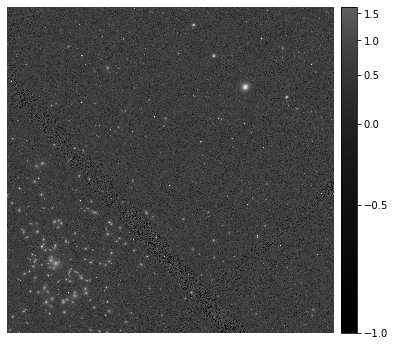

In [44]:
fig = plt.figure(figsize=(10, 6))
afw_display = afwDisplay.Display(1)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(my_new_deepCoadd.image)
plt.gca().axis('off')

#### 4.2.5. Retrieve the configurations for the run

In this example, only one configuration parameter was changed from the default values. This was in Section 3.4 where we set:
`assembleCoaddPipeline.addConfigOverride('makeWarp', 'doApplyFinalizedPsf', False)`.

The configurations can be retrieved for the in `simpleButler` with the following calls.

In [47]:
my_makeWarp_config = simpleButler.get("makeWarp_config", my_dataId)

In [48]:
my_assembleCoadd_config = simpleButler.get("assembleCoadd_config", my_dataId)

Optional: print all of the keys and values for each pipeline tasks's configuration.

In [51]:
# for key, value in my_makeWarp_config.items():
#     print(key, value)

In [52]:
# for key, value in my_assembleCoadd_config.items():
#     print(key, value)

## 5. Rerun source detection and measurement

> **Help Question:** Working this out in **explore_source_measurement_coadd.ipynb**.



## 6. Exercises for the learner

### 6.1. Create a coadd for date Window2.

### 6.2. Use airmass constraints instead of MJD to identify the subset of visits to coadd.

> Hint: use 
> `my_coadd_visits_airmass = visitTable.loc[my_coadd_inputs.visits['id']]['airmass']`

## 7. Known Limitations

1. In order to make multiple different deepCoadds, e.g., one per week over a multi-week period, the user needs to repeat the process starting with making the simpleButler. Each new deepCoadd would be stored with the same name, "deepCoadd", but with a different Butler collection timestamp. The user would be able to tell which new deepCoadd was composed of which visits using the ".coaddInputs" as above.